In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression, f_classif

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
SEED = 42

# Data Preprocessing 

In [3]:
import os
os.getcwd()

'/content'

In [0]:
# load training data

# load data from csv file

HOMEDIR = './drive/My Drive/IML Projects/task_2'
df_train_features = pd.read_csv(HOMEDIR + "/train_features.csv")
df_train_labels = pd.read_csv(HOMEDIR + '/train_labels.csv')

# Load test data
df_test_features = pd.read_csv(HOMEDIR + '/test_features.csv')

In [0]:
df_train_labels = df_train_labels.sort_values('pid')
df_train_features = df_train_features.sort_values(['pid','Time'])
df_test_features = df_test_features.sort_values(['pid','Time'])

# # Droping time
# df_train_features = df_train_features.drop('Time', axis = 1)
# df_test_features = df_test_features.drop('Time', axis = 1)

In [0]:
train_pids = df_train_features['pid'].unique()
test_pids = df_test_features['pid'].unique()

# Imputation and aggregation

### Training data

In [0]:
# can also use data.interpolate to do a linear interpolation of the missing values
df_train_patient = df_train_features.groupby(['pid'], as_index=False).apply(lambda group: group.interpolate(method = 'linear', limit_direction = "both"))

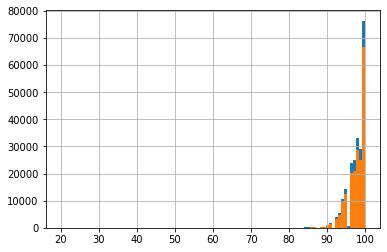

In [8]:
df_train_patient['SpO2'].hist(bins = 100)
df_train_features['SpO2'].hist(bins = 100)

In [9]:
# Which columns have less than a percent NA
NA_percent = 0.85
NA_percent_severe = 0.91

sel_features = df_train_features.isnull().sum(axis=0) < (NA_percent * df_train_features.shape[0])
inds = np.where(sel_features == True)

sel_features_2 = (df_train_features.isnull().sum(axis=0) <= (NA_percent_severe * df_train_features.shape[0])) & (df_train_features.isnull().sum(axis=0) >= (NA_percent * df_train_features.shape[0]))        
inds_2 = np.where(sel_features_2 == True)

sel_features_3 = df_train_features.isnull().sum(axis=0) > (NA_percent_severe * df_train_features.shape[0])
inds_3 = np.where(sel_features_3 == True)

vars_class1 = df_train_features.columns[inds[0]]
vars_class2 = df_train_features.columns[inds_2[0]]
vars_class3 = df_train_features.columns[inds_3[0]]
vars_classes = [vars_class1, vars_class2, vars_class3]

print("--------Our Columns are are: ",df_train_features.columns.drop("pid"))
print("--------Labels are: ", df_train_labels.columns)
print("********Var classes are: " ,vars_classes)

--------Our Columns are are:  Index(['Time', 'Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine',
       'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm',
       'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2',
       'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total',
       'TroponinI', 'ABPs', 'pH'],
      dtype='object')
--------Labels are:  Index(['pid', 'LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST',
       'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate',
       'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct',
       'LABEL_EtCO2', 'LABEL_Sepsis', 'LABEL_RRate', 'LABEL_ABPm',
       'LABEL_SpO2', 'LABEL_Heartrate'],
      dtype='object')
********Var classes are:  [Index(['pid', 'Time', 'Age', 'Temp', 'RRate', 'Glucose', 'ABPm', 'ABPd',
       'SpO2', 'Heartrate', 'ABPs'],
      dtype='object'), Index(['Hgb', 'P

In [0]:
# Extract Statistics out of columns
train_columns_mean = df_train_features.mean(skipna = True)
train_columns_median = df_train_features.median(skipna = True)

# Extract Statistics out of test
test_columns_mean = df_test_features.mean(skipna = True)
test_columns_median = df_test_features.median(skipna = True)

In [0]:
# from scipy import stats

# def aggregation_imputation_technique(datInp, variables, vars_classes, pids, trainStats):
    
#     dat = copy.deepcopy(datInp)
    
#     vars_class1 = vars_classes[0]
#     vars_class2 = vars_classes[1]
#     vars_class3 = vars_classes[2]
    
#     aggregated_dataframe = []
#     for pid in pids:
#         # dataframe for this pid
#         df = dat.loc[dat['pid'] == pid]
        
#         imputer = KNNImputer(n_neighbors=3)

#         df = imputation_pid(df, imputer, trainStats)

#         calculated_features = []
#         col_names = []
#         for var in variables:

#             # how many NaN are in there for this variable
#             data = df[var].tolist()
            
#             if var == "pid":
#                 continue
                
#             if var == "Age":
#                 arr = "Age"
#                 col_names.append(arr)
#                 calculated_features.append(data[0])
                
#             elif var in vars_class1:
#                 for i in range(12):
#                     col_names.append(var + ":" + str(i))
                
#                 calculated_features = calculated_features + data
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
#                 calculated_features.append(stats.iqr(data, nan_policy = "omit"))
                
#                 col_names.append(var + ":mean")
#                 col_names.append(var + ":std")
#                 col_names.append(var + ":iqr")
                
#             elif var in vars_class2:
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
#                 calculated_features.append(np.nanmin(data))
#                 calculated_features.append(np.nanmax(data))
#                 calculated_features.append(stats.iqr(data, nan_policy = "omit"))
                
#                 col_names.append(var + ":mean")
#                 col_names.append(var + ":std")
#                 col_names.append(var + ":min")
#                 col_names.append(var + ":max")
#                 col_names.append(var + ":iqr")
            
#             else:
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
#                 calculated_features.append(np.nanmin(data))
#                 calculated_features.append(np.nanmax(data))
                
#                 col_names.append(var + ":mean")
#                 col_names.append(var + ":std")
#                 col_names.append(var + ":min")
#                 col_names.append(var + ":max")
                
#         aggregated_dataframe.append(calculated_features)
        
#     aggregated_dataframe = pd.DataFrame(aggregated_dataframe, columns = col_names)
        
#     return(aggregated_dataframe)

# df_train_agg_features = aggregation_imputation_technique(df_train_patient, df_train_patient.columns, vars_classes,
#                                                          train_pids)
# print(df_train_agg_features)

In [0]:
nancount = lambda x: x.isna().sum()
df_train_agg_features = df_train_patient.groupby('pid').agg([("mean", np.nanmean)
                                                            ,("std", np.nanstd), 
                                                             'last', 'first',
                                                             ("nancount", nancount)])

In [13]:
# Dropping time and age features
df_train_agg_features = df_train_agg_features.drop(df_train_agg_features.columns[[0,1,2,3,4,6,7,8,9]], axis = 1)
df_train_agg_features

Age EtCO2                 ...        pH                               
       mean  mean std last first  ...      mean       std  last first nancount
pid                               ...                                         
1      34.0   NaN NaN  NaN   NaN  ...  7.381667  0.027047  7.39  7.33      0.0
2      86.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
4      66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
6      66.0   NaN NaN  NaN   NaN  ...  7.348333  0.016422  7.34  7.35      0.0
8      42.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
...     ...   ...  ..  ...   ...  ...       ...       ...   ...   ...      ...
31653  52.0   NaN NaN  NaN   NaN  ...  7.330000  0.000000  7.33  7.33      0.0
31654  66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31656  44.0   NaN NaN  NaN   NaN  ...  7.306667  0.035054  7.33  7.25      0.0
31657  70.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31658  60.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0

[18995 rows x 171 columns]

In [14]:
imp_mean = IterativeImputer(random_state=SEED, skip_complete = True, add_indicator=True,
                            max_iter = 30)
data_train_imputed = imp_mean.fit_transform(df_train_agg_features)
# data_train_imputed = pd.DataFrame(data_train_imputed, columns = df_train_agg_features.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


ValueError: ignored

In [0]:
data_train_imputed = pd.DataFrame(data_train_imputed)

### Test data

In [0]:
# can also use data.interpolate to do a linear interpolation of the missing values
df_test_patient = df_test_features.groupby(['pid'], as_index=False).apply(lambda group: group.interpolate(method = 'linear'))

In [0]:
nancount = lambda x: x.isna().sum()
df_test_agg_features = df_test_patient.groupby('pid').agg([("mean", np.nanmean)
                                                            ,("std", np.nanstd), 
                                                             'last', 'first',
                                                             ("nancount", nancount)])

In [28]:
# Dropping time and age features
df_test_agg_features = df_test_agg_features.drop(df_test_agg_features.columns[[0,1,2,3,4,6,7,8,9]], axis = 1)
df_test_agg_features

Age EtCO2                 ...        pH                               
       mean  mean std last first  ...      mean       std  last first nancount
pid                               ...                                         
0      39.0   NaN NaN  NaN   NaN  ...  7.382000  0.022804  7.40  7.34      2.0
3      84.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
5      62.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
7      71.0   NaN NaN  NaN   NaN  ...  7.367500  0.014880  7.36  7.40      4.0
9      51.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
...     ...   ...  ..  ...   ...  ...       ...       ...   ...   ...      ...
31647  29.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31649  83.0   NaN NaN  NaN   NaN  ...  7.278182  0.014118  7.30  7.26      1.0
31651  74.0   NaN NaN  NaN   NaN  ...  7.370455  0.024307  7.38  7.41      1.0
31652  40.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31655  23.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0

[12664 rows x 171 columns]

In [45]:
# imp_mean = IterativeImputer(random_state=SEED, skip_complete = True)

imp_mean = IterativeImputer(random_state=SEED, skip_complete = True, add_indicator=True,
                            max_iter = 30)
data_test_imputed = imp_mean.fit_transform(df_test_agg_features)
# data_test_imputed = pd.DataFrame(data_test_imputed, columns = df_test_agg_features.columns)
data_train_imputed = pd.DataFrame(data_train_imputed)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Standardizing the data

In [0]:
standard_scalar = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = standard_scalar.fit_transform(data_train_imputed)
data_train_scaled = pd.DataFrame(data_train_scaled)

data_test_scaled = standard_scalar.transform(data_test_imputed)
data_test_scaled = pd.DataFrame(data_test_scaled)

In [31]:
data_test_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306
0,-1.402508,-2.690369,0.672119,0.141074,1.419251,0.273502,1.196577,-1.195865,-1.193767,-1.193885,-1.026598,-0.614249,-0.577093,-0.621879,-0.633009,-0.411196,0.582736,0.655541,0.590914,0.597995,0.587341,-0.123984,-0.264280,-0.225024,0.054811,0.397627,-0.660551,-0.589113,-0.613021,0.519335,-0.410357,-1.678365,-0.801349,-3.105032,-1.570169,-1.023940,-2.569579,0.308466,-1.802052,-1.533176,...,-1.733207,-1.733207,-1.733207,-1.733207,-0.034052,-0.034052,-0.034052,-0.034052,0.184147,0.184147,0.184147,0.184147,-1.128972,-1.128972,-1.128972,-1.128972,-0.545492,-0.545492,-0.545492,-0.545492,-0.0192,-0.0192,-0.0192,-0.0192,-1.741279,-1.741279,-1.741279,-1.741279,0.415107,0.415107,0.415107,0.415107,-0.146292,-0.146292,-0.146292,-0.146292,-1.173097,-1.173097,-1.173097,-1.173097
1,1.332752,0.223258,-0.078957,-0.001566,0.114518,0.273502,-0.836071,0.836183,0.836483,0.836444,0.836163,1.662065,1.666209,1.548506,1.658021,1.666461,0.586170,0.594602,0.585842,0.588177,0.587341,-0.480252,-0.264280,-0.304508,-0.120192,4.262710,1.661671,1.672240,1.667620,-1.576351,1.668492,0.831139,0.838206,0.321856,0.839371,0.838073,0.428286,-0.027033,0.448039,0.025931,...,0.576965,0.576965,0.576965,0.576965,-0.034052,-0.034052,-0.034052,-0.034052,0.184147,0.184147,0.184147,0.184147,0.885762,0.885762,0.885762,0.885762,1.833208,1.833208,1.833208,1.833208,-0.0192,-0.0192,-0.0192,-0.0192,0.574290,0.574290,0.574290,0.574290,0.415107,0.415107,0.415107,0.415107,-0.146292,-0.146292,-0.146292,-0.146292,0.852444,0.852444,0.852444,0.852444
2,-0.004486,0.099040,0.107962,-0.060295,0.071368,0.273502,-0.836019,0.836176,0.836576,0.836153,0.836163,1.662441,1.667022,1.548343,1.657977,1.666461,0.587171,0.583484,0.588705,0.586072,0.587341,0.232284,-0.264280,-0.145540,0.229814,1.501937,1.661976,1.669686,1.668128,-1.607471,1.668492,0.831834,0.813731,0.397742,0.835293,0.838073,0.455339,-0.036701,0.422931,0.067743,...,0.576965,0.576965,0.576965,0.576965,-0.034052,-0.034052,-0.034052,-0.034052,0.184147,0.184147,0.184147,0.184147,0.885762,0.885762,0.885762,0.885762,1.833208,1.833208,1.833208,1.833208,-0.0192,-0.0192,-0.0192,-0.0192,0.574290,0.574290,0.574290,0.574290,0.415107,0.415107,0.415107,0.415107,-0.146292,-0.146292,-0.146292,-0.146292,0.852444,0.852444,0.852444,0.852444
3,0.542566,-4.378487,-2.131433,2.578371,2.887520,0.273502,1.213344,-1.190666,-0.860412,-1.194911,-0.687914,-0.604537,-0.561108,-0.534733,-0.621121,-0.033440,0.602648,0.603483,0.573637,0.585307,0.587341,0.037956,-0.087365,-0.145540,0.229814,0.397627,-0.704408,-0.556877,-0.604618,0.159119,-0.032385,-1.134822,-0.834709,-0.894610,-1.105764,-0.685392,-0.878700,0.107820,-1.000575,0.406715,...,-1.733207,-1.733207,-1.733207,-1.733207,-0.034052,-0.034052,-0.034052,-0.034052,-5.430430,-5.430430,-5.430430,-5.430430,-1.128972,-1.128972,-1.128972,-1.128972,-0.545492,-0.545492,-0.545492,-0.545492,-0.0192,-0.0192,-0.0192,-0.0192,-1.741279,-1.741279,-1.741279,-1.741279,0.415107,0.415107,0.415107,0.415107,-0.146292,-0.146292,-0.146292,-0.146292,-1.173097,-1.173097,-1.173097,-1.173097
4,-0.673105,-13.696575,-6.478598,-4.728793,19.136301,0.273502,1.194348,-1.196134,-1.203035,-1.197647,0.158795,-0.500432,-0.607338,-0.033642,-0.454693,0.910949,0.589045,0.579346,0.581349,0.584538,0.587341,0.054150,-0.130371,-0.225024,0.229814,3.710556,-0.618510,-0.604843,-0.602938,0.530955,0.912547,-1.283007,-1.268124,-1.210385,-1.248658,0.160977,2.160448,-0.262020,0.430575,-0.022879,...,0.576965,0.576965,0.576965,0.576965,-0.034052,-0.034052,-0.034052,-0.034052,0.184147,0.184147,0.184147,0.184147,-1.128972,-1.128972,-1.128972,-1.128972,-0.545492,-0.545492,-0.545492,-0.545492,-0.0192,-0.0192,-0.0192,-0.0192,0.574290,0.574290,0.574290,0.574290,0.415107,0.415107,0.415107,0.415107,-0.146292

In [0]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_scaled.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_scaled.csv", index = False)

# Prediction

### SCV

For feature  LABEL_BaseExcess
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  5.9min finished


[LibSVM]{'C': 1}
0.9016743372304126
ROC AUC for feature LABEL_BaseExcess  :  0.9173188825913071


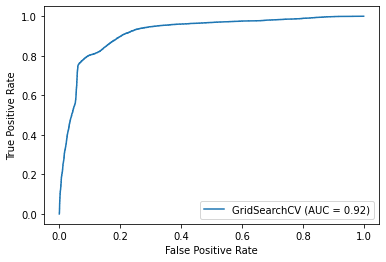

For feature  LABEL_Fibrinogen
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  7.5min finished


[LibSVM]{'C': 0.1}
0.772659034628344
ROC AUC for feature LABEL_Fibrinogen  :  0.7901452117078716


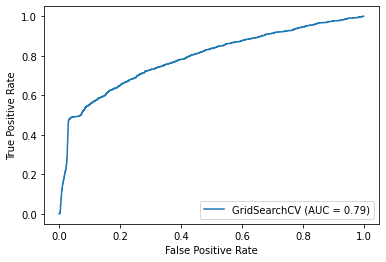

For feature  LABEL_AST
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.5min finished


[LibSVM]{'C': 20}
0.6843183010874604
ROC AUC for feature LABEL_AST  :  0.710106183119313


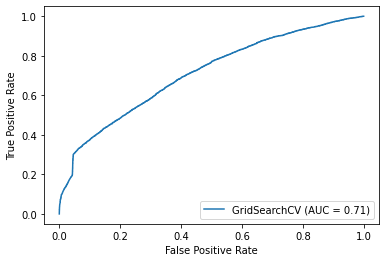

For feature  LABEL_Alkalinephos
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.1min finished


[LibSVM]{'C': 20}
0.6948833328076538
ROC AUC for feature LABEL_Alkalinephos  :  0.717234925956178


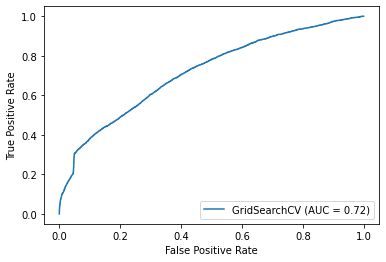

For feature  LABEL_Bilirubin_total
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  9.2min finished


[LibSVM]{'C': 10}
0.6843465597730659
ROC AUC for feature LABEL_Bilirubin_total  :  0.7056537208605592


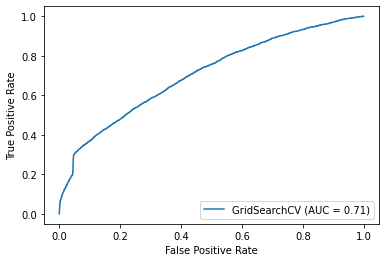

For feature  LABEL_Lactate
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.6min finished


[LibSVM]{'C': 1}
0.7631664331054029
ROC AUC for feature LABEL_Lactate  :  0.7869973775588325


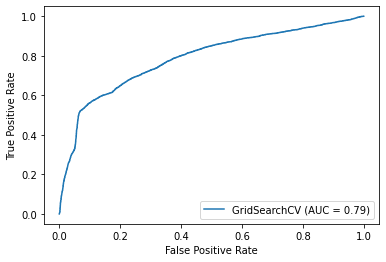

For feature  LABEL_TroponinI
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  5.7min finished


[LibSVM]{'C': 1}
0.8677387399898162
ROC AUC for feature LABEL_TroponinI  :  0.8876524865373636


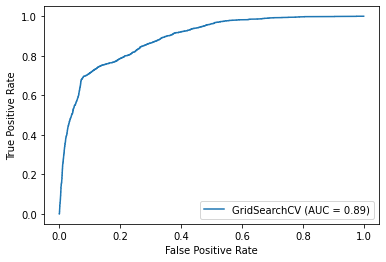

For feature  LABEL_SaO2
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.7min finished


[LibSVM]{'C': 1}
0.7975084816116864
ROC AUC for feature LABEL_SaO2  :  0.814638245123153


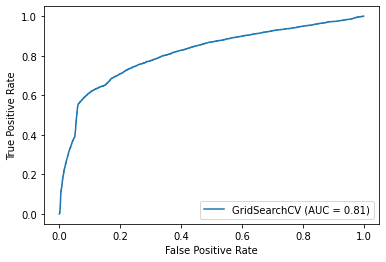

For feature  LABEL_Bilirubin_direct
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.9min finished


[LibSVM]{'C': 1}
0.6947117012117495
ROC AUC for feature LABEL_Bilirubin_direct  :  0.736294094014204


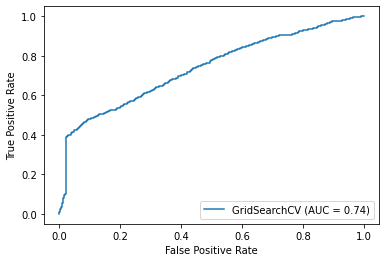

For feature  LABEL_EtCO2
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  4.0min finished


[LibSVM]{'C': 1}
0.9207063466123321
ROC AUC for feature LABEL_EtCO2  :  0.9372329946572187


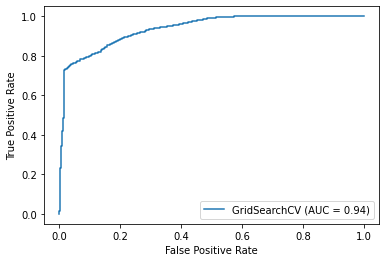

For feature  LABEL_Sepsis
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  8.6min finished


[LibSVM]{'C': 0.1}
0.6828913568137213
ROC AUC for feature LABEL_Sepsis  :  0.7085671291049507


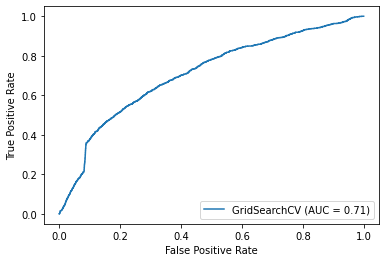

In [49]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.utils import resample

for i in range(1, 12):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=30)
    train_features = pd.DataFrame(transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i]))
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = pd.DataFrame(transformer.transform(data_test_scaled))

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf_w = SVC(kernel = 'rbf', class_weight = 'balanced', verbose = 2)
    
    parameters = {'C':(0.1, 1, 10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                        refit = True, scoring = 'roc_auc', verbose = 2,
                                       n_jobs=6, return_train_score = True)

    clf.fit(train_features, df_train_labels.iloc[:,i])

    print(clf.best_params_)
    print(clf.best_score_)
  
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability_train = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability_train)):
        if distance_hyperplace_train[j] < 0:
            probability_train[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability_train[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_features, df_train_labels.iloc[:,i])
    plt.show()


# Kernelized ridge regression

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.5min finished


[0.87931124 0.88085775 0.89880424 0.90456789 0.90717092 0.90891852
 0.90939636 0.90980959 0.910063  ]
[0.87929829 0.8807191  0.89863455 0.90401492 0.90606251 0.90743626
 0.90794161 0.90821796 0.90835811]
{'C': 30}
0.9083581092740978
ROC AUC for feature LABEL_BaseExcess  :  0.9100090197130837


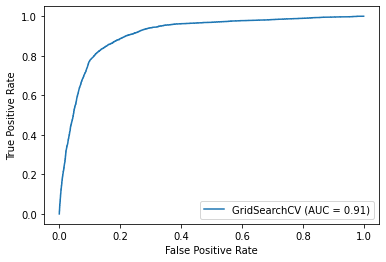

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.9min finished


[0.76405502 0.76585106 0.77228749 0.78003865 0.78830115 0.79376989
 0.79600757 0.79835132 0.79970546]
[0.76378657 0.76550601 0.77081602 0.77592599 0.77831525 0.77895399
 0.7787081  0.77837441 0.77791043]
{'C': 5}
0.7789539859479633
ROC AUC for feature LABEL_Fibrinogen  :  0.7931525595745543


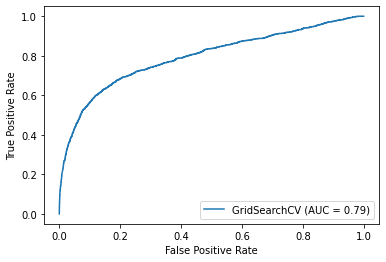

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.9min finished


[0.663504   0.66896068 0.69062734 0.69866322 0.70291901 0.70467537
 0.7055731  0.70655062 0.70713819]
[0.66322864 0.66865754 0.68999337 0.69726785 0.69988842 0.7003125
 0.70056963 0.70094693 0.70122422]
{'C': 30}
0.7012242214006682
ROC AUC for feature LABEL_AST  :  0.7069344705701636


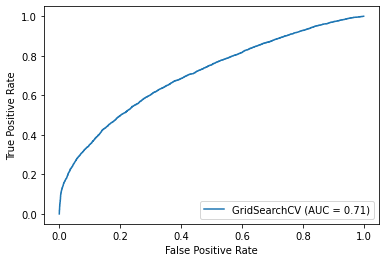

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.9min finished


[0.66661203 0.67210002 0.69362838 0.70121119 0.705202   0.70712534
 0.7080367  0.70902603 0.70962199]
[0.66632398 0.67169487 0.69283805 0.69983809 0.70227673 0.70262193
 0.70295792 0.70329055 0.70347646]
{'C': 30}
0.703476459479895
ROC AUC for feature LABEL_Alkalinephos  :  0.7094137528942017


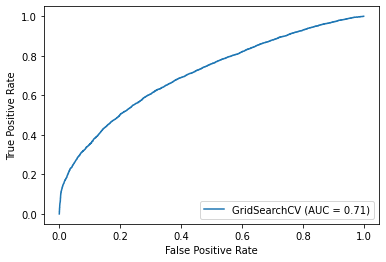

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.9min finished


[0.66537741 0.67196683 0.69340695 0.69892584 0.70285923 0.70493837
 0.70606448 0.70733847 0.70810826]
[0.66537802 0.67178546 0.69273474 0.69738808 0.69989521 0.70040762
 0.70080977 0.70140812 0.70175858]
{'C': 30}
0.7017585838239745
ROC AUC for feature LABEL_Bilirubin_total  :  0.707924198582421


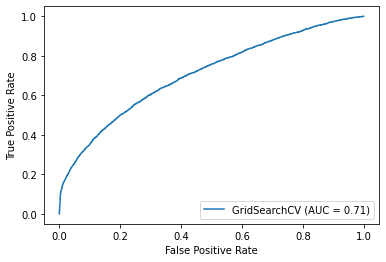

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.8min finished


[0.75406141 0.75930299 0.76127333 0.76454828 0.76724801 0.7705507
 0.77214144 0.77379654 0.77483074]
[0.75399215 0.75890189 0.76048288 0.76232255 0.76179855 0.76253175
 0.7639391  0.76536578 0.76619496]
{'C': 30}
0.7661949600644308
ROC AUC for feature LABEL_Lactate  :  0.7744285538827264


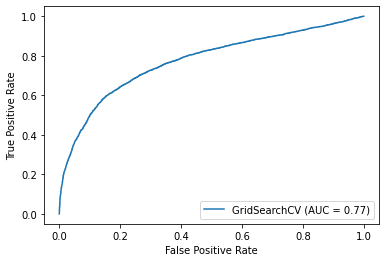

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.5min finished


[0.87038343 0.87168358 0.87884659 0.88399526 0.88837871 0.89014494
 0.89128092 0.89212769 0.89240492]
[0.87031398 0.8715432  0.87867752 0.8831866  0.88723545 0.88819715
 0.88859176 0.88957783 0.88982659]
{'C': 30}
0.889826588075126
ROC AUC for feature LABEL_TroponinI  :  0.8922789427394344


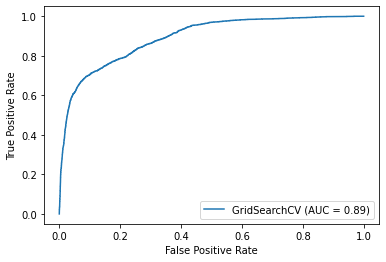

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.7min finished


[0.78719322 0.79119382 0.79997289 0.80376923 0.80739375 0.80888767
 0.80947645 0.81012965 0.81055223]
[0.78701576 0.79096566 0.79982276 0.80323224 0.80559013 0.80609965
 0.80605086 0.80623654 0.80640189]
{'C': 30}
0.806401886674796
ROC AUC for feature LABEL_SaO2  :  0.810456122847768


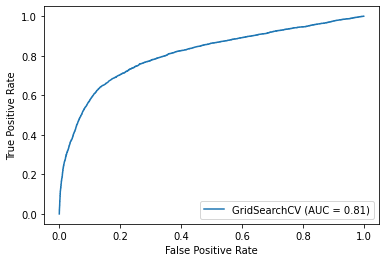

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.7min finished


[0.68166923 0.68934884 0.69790917 0.70356019 0.70827232 0.71196938
 0.7146454  0.71813918 0.72042006]
[0.6797481  0.6878455  0.69645111 0.70006085 0.69652066 0.69707768
 0.69845491 0.69971815 0.69986306]
{'C': 0.1}
0.7000608456495968
ROC AUC for feature LABEL_Bilirubin_direct  :  0.7032302469004177


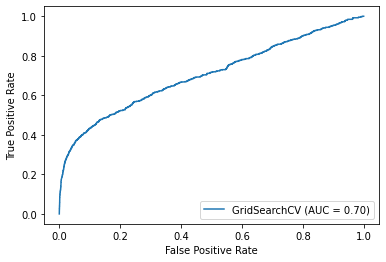

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.6min finished


[0.87024442 0.88600307 0.91290266 0.92396622 0.93079242 0.93327081
 0.93433961 0.93561848 0.9363414 ]
[0.86999069 0.88568483 0.91229551 0.92191791 0.92687394 0.92705801
 0.92691969 0.92750885 0.92785396]
{'C': 30}
0.9278539557646518
ROC AUC for feature LABEL_EtCO2  :  0.9362259921624343


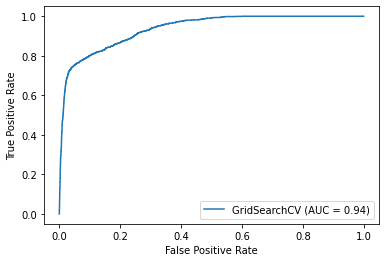

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.0min finished


[0.65116038 0.65603994 0.6767294  0.68238654 0.68956536 0.69599154
 0.69858858 0.70131203 0.70299556]
[0.65003161 0.65416433 0.67423716 0.67778563 0.67986832 0.68216589
 0.68266503 0.68288659 0.68324664]
{'C': 30}
0.6832466430314623
ROC AUC for feature LABEL_Sepsis  :  0.7019817874377092


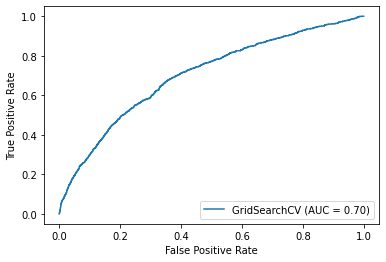

In [39]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve

for i in range(1, 12):
    #     feature selection
    transformer =  GenericUnivariateSelect(score_func= f_classif, mode ='k_best', param = 30)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)


    clf_w = LogisticRegression(penalty = 'l2', class_weight = 'balanced',
                                                               fit_intercept= True, max_iter=10000)
    
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'C':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
#     print("Class weightt is ", clf_w.class_weight_)
 
    probability_tmp = clf.predict_proba(test_transformed)
    probability = [item[1] for item in probability_tmp]
    columns_1.append(probability)

    probability_tmp = clf.predict_proba(train_transformed)
    probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_transformed, df_train_labels.iloc[:,i])
    plt.show()

In [48]:
#labels that have a real value
from sklearn.metrics import make_scorer
columns_2 = []


for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= f_regression, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(data_train_scaled.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    if(i == 14):
        # Bagging the regressor have been tried, does not help
        clf_w = SVR(kernel = 'rbf', tol = 1e-4, cache_size= 7000)
        
        # This parameter vector have been tried, 1 is the best
        #parameters = {'base_estimator__C':(0.001, 0.01, 0.1, 1,10, 20)}
        #parameters = {'C':np.linspace(0.1,1,10)}
        parameters = {'C':(0.001, 0.01, 0.1, 0.5, 1,10)}
    else:
        clf_w = LinearSVR()
        parameters = {'C':(0.001, 0.001, 0.01, 0.1,1,10)}
        
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = make_scorer(r2_score), verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
        
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)



Int64Index([  0,  41,  42,  43,  44,  78, 115, 126, 127, 128, 129, 146, 148,
            149, 152, 169, 259, 260, 261, 262],
           dtype='int64')
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   51.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[-0.80328235 -0.80252835  0.38780512  0.40293472  0.40349695  0.40160081]
[-0.8081718  -0.80740391  0.38680939  0.40183291  0.40247628  0.4016273 ]
{'C': 1}
0.4024762821656694
R2 for feature LABEL_RRate  :  0.40392793709410757
Int64Index([ 31,  34,  35,  96,  98,  99, 113, 114, 140, 161, 163, 164, 195,
            196, 197, 198, 279, 280, 281, 282],
           dtype='int64')
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   12.8s finished


[-26.34583963 -26.34583963   0.4645692    0.60208474   0.60438183
   0.60445113]
[-26.40125145 -26.40125145   0.46360348   0.60102498   0.60338815
   0.60332701]
{'C': 1}
0.6033881455916508
R2 for feature LABEL_ABPm  :  0.6040301291026122
Int64Index([  0,  41,  43,  44,  66,  68,  69,  78, 126, 127, 128, 129, 136,
            138, 141, 143, 144, 166, 168, 169],
           dtype='int64')
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 29.7min finished


[0.09776009 0.24007877 0.29520846 0.34181374 0.37012865 0.54421892]
[0.10164936 0.24780193 0.29369897 0.31298761 0.31720764 0.31691615]
{'C': 1}
0.3172076409946608
R2 for feature LABEL_SpO2  :  0.3696131200808366
Int64Index([  0,  41,  80, 146, 148, 149, 167, 170, 223, 224, 225, 226, 231,
            232, 233, 234, 303, 304, 305, 306],
           dtype='int64')
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    9.0s finished


[-20.73866911 -20.73866911   0.54581301   0.65552682   0.65755351
   0.65769261]
[-20.77598369 -20.77598369   0.54540364   0.65518768   0.65699247
   0.65716951]
{'C': 10}
0.6571695090982214
R2 for feature LABEL_Heartrate  :  0.6578112425922809


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
columns_final = columns_1 + columns_2

# Boosted trees


In [50]:
import xgboost as xgb

columns_2_1 = []
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
# evallist = [(dtrain, 'train')]

standard_scalar = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

train_scaled = standard_scalar.fit_transform(df_train_agg_features)
train_scaled = pd.DataFrame(train_scaled)

test_scaled = standard_scalar.transform(df_test_agg_features)
test_scaled = pd.DataFrame(test_scaled)
for i in range(12,16):
#     transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=80)
#     train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
# #     print(list(data_train_scaled)[transformer.get_support()])
#     test_features = transformer.transform(data_test_scaled)
  clf_w = xgb.XGBRegressor(feval = r2_score, verbosity = 0)
          
  clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = {'max_depth':(3,4,5,6)}, cv = 10,
                                      refit = True, verbose = 1, scoring='r2',
                                      n_jobs=6, return_train_score = True)

  clf.fit(train_scaled, df_train_labels.iloc[:,i])
  print(clf.best_params_)
  print(clf.best_score_)    

  #     dtrain = xgb.DMatrix(df_train_scaled_xgboost, label=df_train_labels.iloc[:,i])
  #     num_round = 10

  probability = clf.predict(test_scaled)
  columns_2_1.append(probability)

  pred_train = clf.predict(train_scaled)
  #     probability_train = [item[1] for item in probability_tmp]
  tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
  print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  7.0min finished


{'max_depth': 4}
0.4434175286096524
R2 for feature LABEL_RRate  :  0.5373506820533771
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  7.0min finished


{'max_depth': 5}
0.6392712667492424
R2 for feature LABEL_ABPm  :  0.7239449230777535
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  6.6min finished


{'max_depth': 3}
0.4149250027253485
R2 for feature LABEL_SpO2  :  0.5564816877855039
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  6.9min finished


{'max_depth': 3}
0.6759049614754247
R2 for feature LABEL_Heartrate  :  0.700828022267588


In [0]:
columns_final = columns_1 + columns_2_1

# Saving the results

In [54]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)
